In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from fetch_data import TitanicData, ModelInput
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

## Fetch Data

In [2]:
t = TitanicData()
t.fetch_data()

## Feature Engineering: First Impressions
New columns representing:
- Fill null Age values with average by Sex, Embarked
- Convert Pclass, Sex, SibSp, and Parch to categorical (get_dummies)
- CabinFlag: 1 or 0
- Cabin Section and make categorical
- LastName
- Scale (after train-test-split)

In [3]:
t.set()

In [4]:
t.data.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin',
       'LastName', 'CabinFlag', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_1',
       'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_Q',
       'Embarked_S', 'Section_B', 'Section_C', 'Section_D', 'Section_E',
       'Section_F', 'Section_G', 'Section_T', 'TicketType_A5', 'TicketType_C',
       'TicketType_CA', 'TicketType_CA/SOTON', 'TicketType_FC',
       'TicketType_FCC', 'TicketType_Fa', 'TicketType_GENERAL',
       'TicketType_P/PP', 'TicketType_PC', 'TicketType_PP', 'TicketType_SC',
       'TicketType_SC/A4', 'TicketType_SC/AH', 'TicketType_SC/PARIS',
       'TicketType_SC/Paris', 'TicketType_SCO/W', 'TicketType_SO/C',
       'TicketType_SO/PP', 'TicketType_SOC', 'TicketType_SOP',
       'TicketType_SOTON/O2', 'TicketType_SOTON/OQ', 'TicketType_SP',
       'TicketType_STON/O2', 'TicketType_SW/PP', 'TicketType_WC',
 

## Build Input for Model
Set the features to be used for training the model. Then do a Train-Test Split and Scale Numerical Data.

In [5]:
mi = ModelInput(t.data, t.test_data)

mi.set_features()
mi.train_test_split(test_size=0.2)
mi.scale()

# Grid Search & Random Forest Classifier
Use GridSearchCV to iteratively train several Random Forest Classifers, find the best parameters, and make predictions.

In [6]:
params = {'n_estimators': [100, 300, 1000, 3000], 'max_depth': [1, 2, 3, 5, 7]}

rf = RandomForestClassifier(criterion='gini', 
                            n_jobs=2, 
                            random_state=123)

gs = GridSearchCV(rf, params, verbose=1)
gs.fit(mi.X_train, mi.y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


GridSearchCV(estimator=RandomForestClassifier(n_jobs=2, random_state=123),
             param_grid={'max_depth': [1, 2, 3, 5, 7],
                         'n_estimators': [100, 300, 1000, 3000]},
             verbose=1)

In [7]:
gs.cv_results_

{'mean_fit_time': array([0.5664782 , 0.58885841, 1.68316283, 5.24542646, 0.25115724,
        0.58218269, 1.70697541, 4.87606206, 0.26042476, 0.59816256,
        1.76909904, 5.11427875, 0.239784  , 0.63674064, 1.7822578 ,
        5.17233491, 0.24717216, 0.63929787, 1.80617199, 5.4191401 ]),
 'std_fit_time': array([0.61573286, 0.02306343, 0.02750674, 0.50485767, 0.02595954,
        0.01208422, 0.04885157, 0.20574812, 0.03808886, 0.02336402,
        0.11543505, 0.44998726, 0.01412674, 0.0645242 , 0.05062499,
        0.24839705, 0.0100355 , 0.02754624, 0.04261532, 0.27652391]),
 'mean_score_time': array([0.10699081, 0.10496044, 0.30700841, 0.73085208, 0.10514488,
        0.10455952, 0.30693789, 0.75149751, 0.10532022, 0.12603655,
        0.3076046 , 0.77248187, 0.10510635, 0.10517302, 0.30683069,
        0.7310298 , 0.10511622, 0.10476069, 0.30667372, 0.73179011]),
 'std_score_time': array([2.73461571e-03, 3.78758001e-04, 5.26817185e-04, 4.12981074e-02,
        2.49086633e-04, 1.96325191e-

Optimized results from GridSearchCV.cv_results_ can be obtained by doing the following:

In [8]:
best_idx = gs.cv_results_['rank_test_score'].argmin()
best_params = gs.cv_results_['params'][best_idx]
print(f'Best Params: {best_params}')

Best Params: {'max_depth': 7, 'n_estimators': 1000}


## Apply Parameters to Classifier
An optimal max_depth of 7 might result in overfitting. Dialing down this param did, indeed, improve the score by 0.012 upon submission of the predictions on the unseen data.

In [17]:
# rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
#                             max_depth=best_params['max_depth'], 
#                             criterion='gini', 
#                             n_jobs=2, 
#                             random_state=123)

rf = RandomForestClassifier(n_estimators=10000, 
                            max_depth=4, 
                            criterion='gini', 
                            class_weight=None,
                            n_jobs=2, 
                            random_state=123)


In [18]:
rf.fit(mi.X_train, mi.y_train)
y_pred = rf.predict(mi.X_test)

In [19]:
acc = accuracy_score(mi.y_test, y_pred)
f1 = f1_score(mi.y_test, y_pred)
cm = confusion_matrix(mi.y_test, y_pred)

print(f'Accuracy: \t{acc}')
print(f'F1: \t\t{f1}')
print(f'Confusion Matrix: \n{cm}')

Accuracy: 	0.8324022346368715
F1: 		0.7321428571428572
Confusion Matrix: 
[[108   6]
 [ 24  41]]


## Feature Importance

Text(0.5, 0, 'Average Contribution to Information Gain')

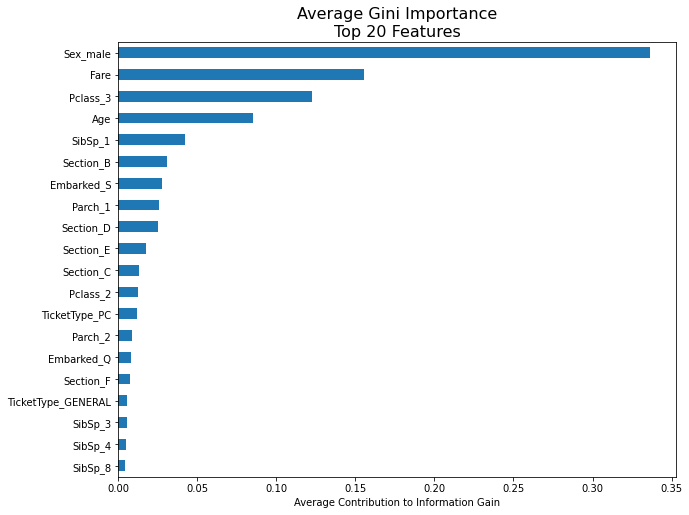

In [20]:
feat_scores = pd.Series(rf.feature_importances_, 
                        index=mi.X_train.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(10, 8))
ax.set_title('Average Gini Importance\nTop 20 Features', fontsize=16)
ax.set_xlabel('Average Contribution to Information Gain')

# Unseen Test Data
Create predictions on unseen test data for submission. The features in unseen data were already modified and scaled in the ModelInput class.

Make predictions, write results to csv, then submit using the Kaggle API.

In [21]:
mi.hidden_data.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,TicketType_SO/PP,TicketType_SOC,TicketType_SOP,TicketType_SOTON/O2,TicketType_SOTON/OQ,TicketType_SP,TicketType_STON/O2,TicketType_SW/PP,TicketType_WC,TicketType_WEP
0,0.428248,0.015282,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.585323,0.013663,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.773813,0.018909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.334004,0.016908,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.271174,0.023984,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y_pred_submit = rf.predict(mi.hidden_data)

In [23]:
submission = pd.DataFrame(data={
    'PassengerId': t.test_data.loc[:, 'PassengerId'], 
    'Survived': y_pred_submit})

submission.to_csv('../data/rf_output_cleaned_tix_v11.csv', index=False)

In [24]:
!kaggle competitions submit -c titanic -f ../data/rf_output_cleaned_tix_v11.csv -m "random forest classifier"

100%|██████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 1.13kB/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (17 hours from now).
